In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(42)


In [2]:
companies = pd.DataFrame([
    {
        "company": "Company_A_Curated",
        "logic": "Curated discovery, staff picks, browsing-led purchases; stronger fiction uplift and repeat readers.",
        "baseline_units_multiplier": 1.15,
        "avg_discount_from_rrp": 0.40,   # retailer pays ~60% of RRP as COGS (simplified)
        "operating_cost_rate": 0.18,     # operating costs as % of revenue (simplified)
        "promo_depth": 0.10              # promo markdown depth
    },
    {
        "company": "Company_B_Convenience",
        "logic": "Convenience footfall, travel hubs, gifting; more impulse buys, fewer deep backlist sales.",
        "baseline_units_multiplier": 0.90,
        "avg_discount_from_rrp": 0.42,
        "operating_cost_rate": 0.16,
        "promo_depth": 0.07
    }
])

companies


,company,logic,baseline_units_multiplier,avg_discount_from_rrp,operating_cost_rate,promo_depth
0,Company_A_Curated,"Curated discovery, staff picks, browsing-led p...",1.15,0.40,0.18,0.10
1,Company_B_Convenience,"Convenience footfall, travel hubs, gifting; mo...",0.90,0.42,0.16,0.07


In [3]:
regions = [
    "London", "South East", "South West", "East of England",
    "West Midlands", "East Midlands", "North West", "North East", "Yorkshire & Humber"
]

store_plan = []
store_id = 1

for _, row in companies.iterrows():
    company = row["company"]

    # illustrative store counts
    if company == "Company_A_Curated":
        region_store_counts = [26, 20, 12, 12, 10, 9, 14, 7, 10]  # total 120
    else:
        region_store_counts = [14, 10, 7, 7, 6, 5, 8, 4, 5]       # total 66

    for r, n in zip(regions, region_store_counts):
        for _ in range(n):
            base = {
                "London": 1.35, "South East": 1.15, "South West": 0.95, "East of England": 0.95,
                "West Midlands": 0.90, "East Midlands": 0.85, "North West": 0.95,
                "North East": 0.78, "Yorkshire & Humber": 0.88
            }[r]

            store_plan.append({
                "store_id": f"S{store_id:04d}",
                "company": company,
                "region": r,
                "footfall_index": base * np.random.normal(1.0, 0.08)
            })
            store_id += 1

stores = pd.DataFrame(store_plan)
stores.head(), stores.shape


(  store_id            company  region  footfall_index
 0    S0001  Company_A_Curated  London        1.403645
 1    S0002  Company_A_Curated  London        1.335067
 2    S0003  Company_A_Curated  London        1.419950
 3    S0004  Company_A_Curated  London        1.514487
 4    S0005  Company_A_Curated  London        1.324711,
 (186, 4))

In [4]:
titles = [
    "Foundation", "Foundation and Empire", "Second Foundation",
    "I, Robot", "The Caves of Steel", "The Naked Sun",
    "The Robots of Dawn", "Prelude to Foundation", "Forward the Foundation",
    "The End of Eternity", "Nightfall", "The Gods Themselves"
]

formats = ["Paperback", "Hardback", "eBook"]

def sample_rrp(fmt):
    if fmt == "Paperback":
        return np.round(np.random.uniform(8.99, 12.99), 2)
    if fmt == "Hardback":
        return np.round(np.random.uniform(16.99, 22.99), 2)
    return np.round(np.random.uniform(4.99, 9.99), 2)


In [5]:
age_bands = ["13-17", "18-24", "25-34", "35-44", "45-54", "55-64", "65+"]
customer_types = ["Avid Reader", "Casual Reader", "Gift Buyer", "Student", "Commuter/Traveler"]

demo_weights = {
    "Company_A_Curated": {
        "age": np.array([0.06, 0.18, 0.22, 0.16, 0.14, 0.14, 0.10]),
        "type": np.array([0.36, 0.24, 0.14, 0.16, 0.10])
    },
    "Company_B_Convenience": {
        "age": np.array([0.05, 0.14, 0.18, 0.16, 0.16, 0.16, 0.15]),
        "type": np.array([0.18, 0.22, 0.26, 0.10, 0.24])
    }
}


In [6]:
weeks = pd.date_range("2025-01-06", periods=52, freq="W-MON")

def seasonal_multiplier(week_idx):
    if week_idx >= 47:      # Christmas peak
        return 1.55
    if 25 <= week_idx <= 34:  # summer bump
        return 1.12
    if week_idx <= 4:       # Jan dip
        return 0.92
    return 1.0

promo_weeks = set([10, 11, 12, 33, 34])


In [7]:
rows = []
tx_per_store_week = 18

for week_idx, week in enumerate(weeks, start=1):
    seas = seasonal_multiplier(week_idx)
    is_promo = week_idx in promo_weeks

    for _, st in stores.iterrows():
        company = st["company"]
        foot = st["footfall_index"]

        comp = companies.loc[companies["company"] == company].iloc[0]
        base_mult = comp["baseline_units_multiplier"]
        avg_disc = comp["avg_discount_from_rrp"]
        op_cost_rate = comp["operating_cost_rate"]
        promo_depth = comp["promo_depth"] if is_promo else 0.0

        tx_n = int(np.clip(np.random.poisson(tx_per_store_week * foot * seas * base_mult), 4, 80))

        age_probs = demo_weights[company]["age"]
        type_probs = demo_weights[company]["type"]

        for _ in range(tx_n):
            title = np.random.choice(titles)
            fmt = np.random.choice(formats, p=[0.72, 0.18, 0.10])

            rrp = sample_rrp(fmt)

            if company == "Company_A_Curated":
                units = np.random.choice([1, 2, 3, 4], p=[0.78, 0.16, 0.05, 0.01])
            else:
                units = np.random.choice([1, 2, 3, 4], p=[0.86, 0.11, 0.025, 0.005])

            sell_price = np.round(rrp * (1 - promo_depth), 2)
            cogs_unit = np.round(rrp * (1 - avg_disc), 2)

            revenue = sell_price * units
            cogs = cogs_unit * units
            gross_profit = revenue - cogs
            operating_cost = revenue * op_cost_rate
            net_profit = gross_profit - operating_cost

            age_band = np.random.choice(age_bands, p=age_probs)
            cust_type = np.random.choice(customer_types, p=type_probs)

            if company == "Company_A_Curated":
                channel = np.random.choice(["In-Store", "Online"], p=[0.78, 0.22])
            else:
                channel = np.random.choice(["In-Store", "Online"], p=[0.86, 0.14])

            rows.append({
                "week_start": week,
                "week_num": week_idx,
                "company": company,
                "store_id": st["store_id"],
                "region": st["region"],
                "title": title,
                "format": fmt,
                "channel": channel,
                "is_promo_week": is_promo,
                "units": units,
                "rrp": rrp,
                "sell_price": sell_price,
                "revenue": np.round(revenue, 2),
                "cogs": np.round(cogs, 2),
                "gross_profit": np.round(gross_profit, 2),
                "operating_cost": np.round(operating_cost, 2),
                "net_profit": np.round(net_profit, 2),
                "age_band": age_band,
                "customer_type": cust_type
            })

df = pd.DataFrame(rows)

df.shape, df.head(10)


((207431, 19),
   week_start  week_num            company store_id  region  \
 0 2025-01-06         1  Company_A_Curated    S0001  London   
 1 2025-01-06         1  Company_A_Curated    S0001  London   
 2 2025-01-06         1  Company_A_Curated    S0001  London   
 3 2025-01-06         1  Company_A_Curated    S0001  London   
 4 2025-01-06         1  Company_A_Curated    S0001  London   
 5 2025-01-06         1  Company_A_Curated    S0001  London   
 6 2025-01-06         1  Company_A_Curated    S0001  London   
 7 2025-01-06         1  Company_A_Curated    S0001  London   
 8 2025-01-06         1  Company_A_Curated    S0001  London   
 9 2025-01-06         1  Company_A_Curated    S0001  London   
 
                    title     format   channel  is_promo_week  units    rrp  \
 0      Second Foundation      eBook  In-Store          False      1   5.37   
 1  Foundation and Empire  Paperback  In-Store          False      1  12.73   
 2          The Naked Sun  Paperback  In-Store       

In [8]:
weekly_company = (
    df.groupby(["company", "week_start"], as_index=False)
      .agg(units=("units", "sum"),
           revenue=("revenue", "sum"),
           gross_profit=("gross_profit", "sum"),
           net_profit=("net_profit", "sum"))
)

yearly_company = (
    df.groupby(["company"], as_index=False)
      .agg(units=("units", "sum"),
           revenue=("revenue", "sum"),
           gross_profit=("gross_profit", "sum"),
           net_profit=("net_profit", "sum"))
)

weekly_company.head(), yearly_company


(             company week_start  units   revenue  gross_profit  net_profit
 0  Company_A_Curated 2025-01-06   3129  38583.86      15433.74     8489.03
 1  Company_A_Curated 2025-01-13   3059  37773.10      15109.14     8310.03
 2  Company_A_Curated 2025-01-20   2995  36737.07      14694.74     8081.97
 3  Company_A_Curated 2025-01-27   3015  37194.14      14877.68     8182.75
 4  Company_A_Curated 2025-02-03   3212  39310.29      15724.01     8648.06,
                  company   units     revenue  gross_profit  net_profit
 0      Company_A_Curated  186113  2262549.37     891805.56   484554.10
 1  Company_B_Convenience   73960   897964.60     373762.04   230087.67)

In [9]:
demo_age = (
    df.groupby(["company", "age_band"], as_index=False)
      .agg(units=("units", "sum"),
           revenue=("revenue", "sum"),
           net_profit=("net_profit", "sum"))
)

demo_type = (
    df.groupby(["company", "customer_type"], as_index=False)
      .agg(units=("units", "sum"),
           revenue=("revenue", "sum"),
           net_profit=("net_profit", "sum"))
)

demo_age, demo_type


(                  company age_band  units    revenue  net_profit
 0       Company_A_Curated    13-17  11225  136349.67    29212.21
 1       Company_A_Curated    18-24  33487  407992.40    87412.38
 2       Company_A_Curated    25-34  41268  501688.05   107482.59
 3       Company_A_Curated    35-44  29881  362683.60    77641.41
 4       Company_A_Curated    45-54  25648  311590.50    66713.97
 5       Company_A_Curated    55-64  25775  313487.45    67099.46
 6       Company_A_Curated      65+  18829  228757.70    48992.08
 7   Company_B_Convenience    13-17   3504   42902.12    10987.52
 8   Company_B_Convenience    18-24  10458  127539.24    32677.51
 9   Company_B_Convenience    25-34  13318  162331.48    41601.26
 10  Company_B_Convenience    35-44  11871  143366.91    36738.58
 11  Company_B_Convenience    45-54  11727  142436.49    36493.83
 12  Company_B_Convenience    55-64  11978  145406.61    37255.96
 13  Company_B_Convenience      65+  11104  133981.75    34333.01,
         

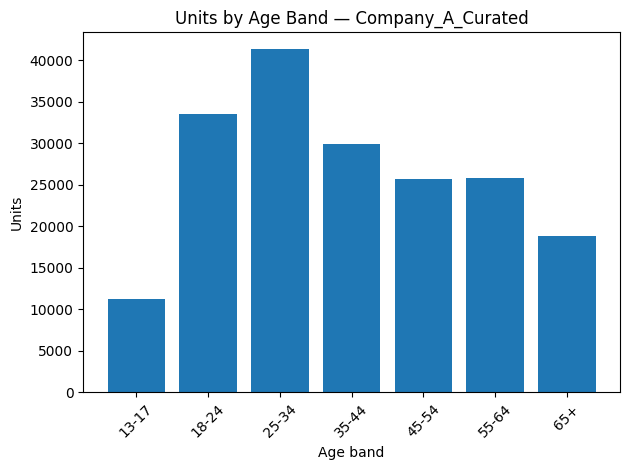

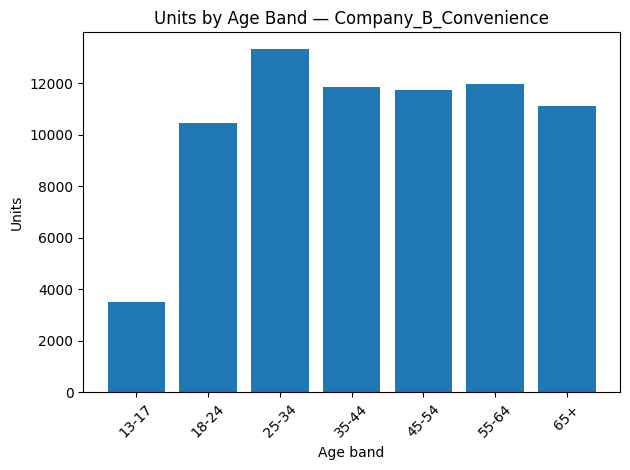

In [10]:
# Units by age band
for comp_name in df["company"].unique():
    sub = demo_age[demo_age["company"] == comp_name].copy()
    sub["age_band"] = pd.Categorical(sub["age_band"], categories=age_bands, ordered=True)
    sub = sub.sort_values("age_band")

    plt.figure()
    plt.bar(sub["age_band"].astype(str), sub["units"])
    plt.title(f"Units by Age Band — {comp_name}")
    plt.xlabel("Age band")
    plt.ylabel("Units")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [11]:
df.to_csv("asimov_england_sales_synthetic.csv", index=False)
weekly_company.to_csv("asimov_weekly_summary.csv", index=False)
yearly_company.to_csv("asimov_yearly_summary.csv", index=False)

print("Saved: asimov_england_sales_synthetic.csv, asimov_weekly_summary.csv, asimov_yearly_summary.csv")


Saved: asimov_england_sales_synthetic.csv, asimov_weekly_summary.csv, asimov_yearly_summary.csv
